## Multi-Label Classification with an Enzyme Substrates

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from tqdm.auto import tqdm
import time

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, cross_val_score
from xgboost import XGBClassifier
import optuna

c:\Users\kimhy\anaconda3\envs\ts\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
def summary(df):
    print(f'df shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum() # number of missing values
    summ['%missing'] = df.isnull().sum()/len(df) * 100 # percentage of missing values
    summ['#unique'] = df.nunique() # number of unique values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['average'] = desc['mean'].values
    summ['std'] = desc['std'].values
    summ['first value'] = df.loc[0]
    summ['second value'] = df.loc[1]
    summ['third value'] = df.loc[2]

    return summ

In [4]:
summary(train)

df shape: (14838, 38)


,data type,#missing,%missing,#unique,min,max,average,std,first value,second value,third value
id,int64,0,0.0,14838,0.000000,14837.000000,7418.500000,4283.505982,0.000000,1.000000,2.000000
BertzCT,float64,0,0.0,2368,0.000000,4069.959780,515.153604,542.456370,323.390782,273.723798,521.643822
Chi1,float64,0,0.0,1259,0.000000,69.551167,9.135189,6.819989,9.879918,7.259037,10.911303
Chi1n,float64,0,0.0,3157,0.000000,50.174588,5.854307,4.647064,5.875576,4.441467,8.527859
Chi1v,float64,0,0.0,3306,0.000000,53.431954,6.738497,5.866444,5.875576,5.834958,11.050864
Chi2n,float64,0,0.0,3634,0.000000,32.195368,4.432570,3.760516,4.304757,3.285046,6.665291
Chi2v,float64,0,0.0,3725,0.000000,34.579313,5.253221,4.925065,4.304757,4.485235,9.519706
Chi3v,float64,0,0.0,3448,0.000000,22.880836,3.418749,3.436208,2.754513,2.201375,5.824822
Chi4n,float64,0,0.0,2930,0.000000,16.072810,1.773472,1.865898,1.749203,1.289775,1.770579
EState_VSA1,float64,0,0.0,719,0.000000,363.705954,29.202823,31.728679,0.000000,45.135471,15.645394


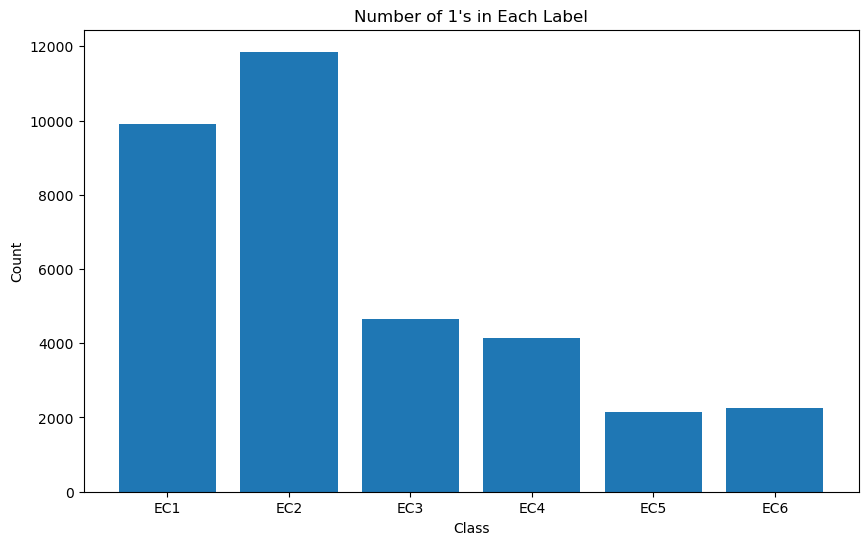

In [5]:
# label columns
labels = ['EC1', 'EC2', 'EC3', 'EC4', 'EC5', 'EC6']
# label counts for each label
counts = [train[label].sum() for label in labels]
# plot
plt.figure(figsize=(10,6))
plt.bar(labels, counts)
plt.title("Number of 1's in Each Label")
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [6]:
# feature columns
columns = list(train.columns)
features = [col for col in columns if col not in ['id', 'EC1', 'EC2', 'EC3', 'EC4', 'EC5', 'EC6']]

print(features)
print(len(features))

['BertzCT', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3v', 'Chi4n', 'EState_VSA1', 'EState_VSA2', 'ExactMolWt', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'HallKierAlpha', 'HeavyAtomMolWt', 'Kappa3', 'MaxAbsEStateIndex', 'MinEStateIndex', 'NumHeteroatoms', 'PEOE_VSA10', 'PEOE_VSA14', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'SMR_VSA10', 'SMR_VSA5', 'SlogP_VSA3', 'VSA_EState9', 'fr_COO', 'fr_COO2']
31


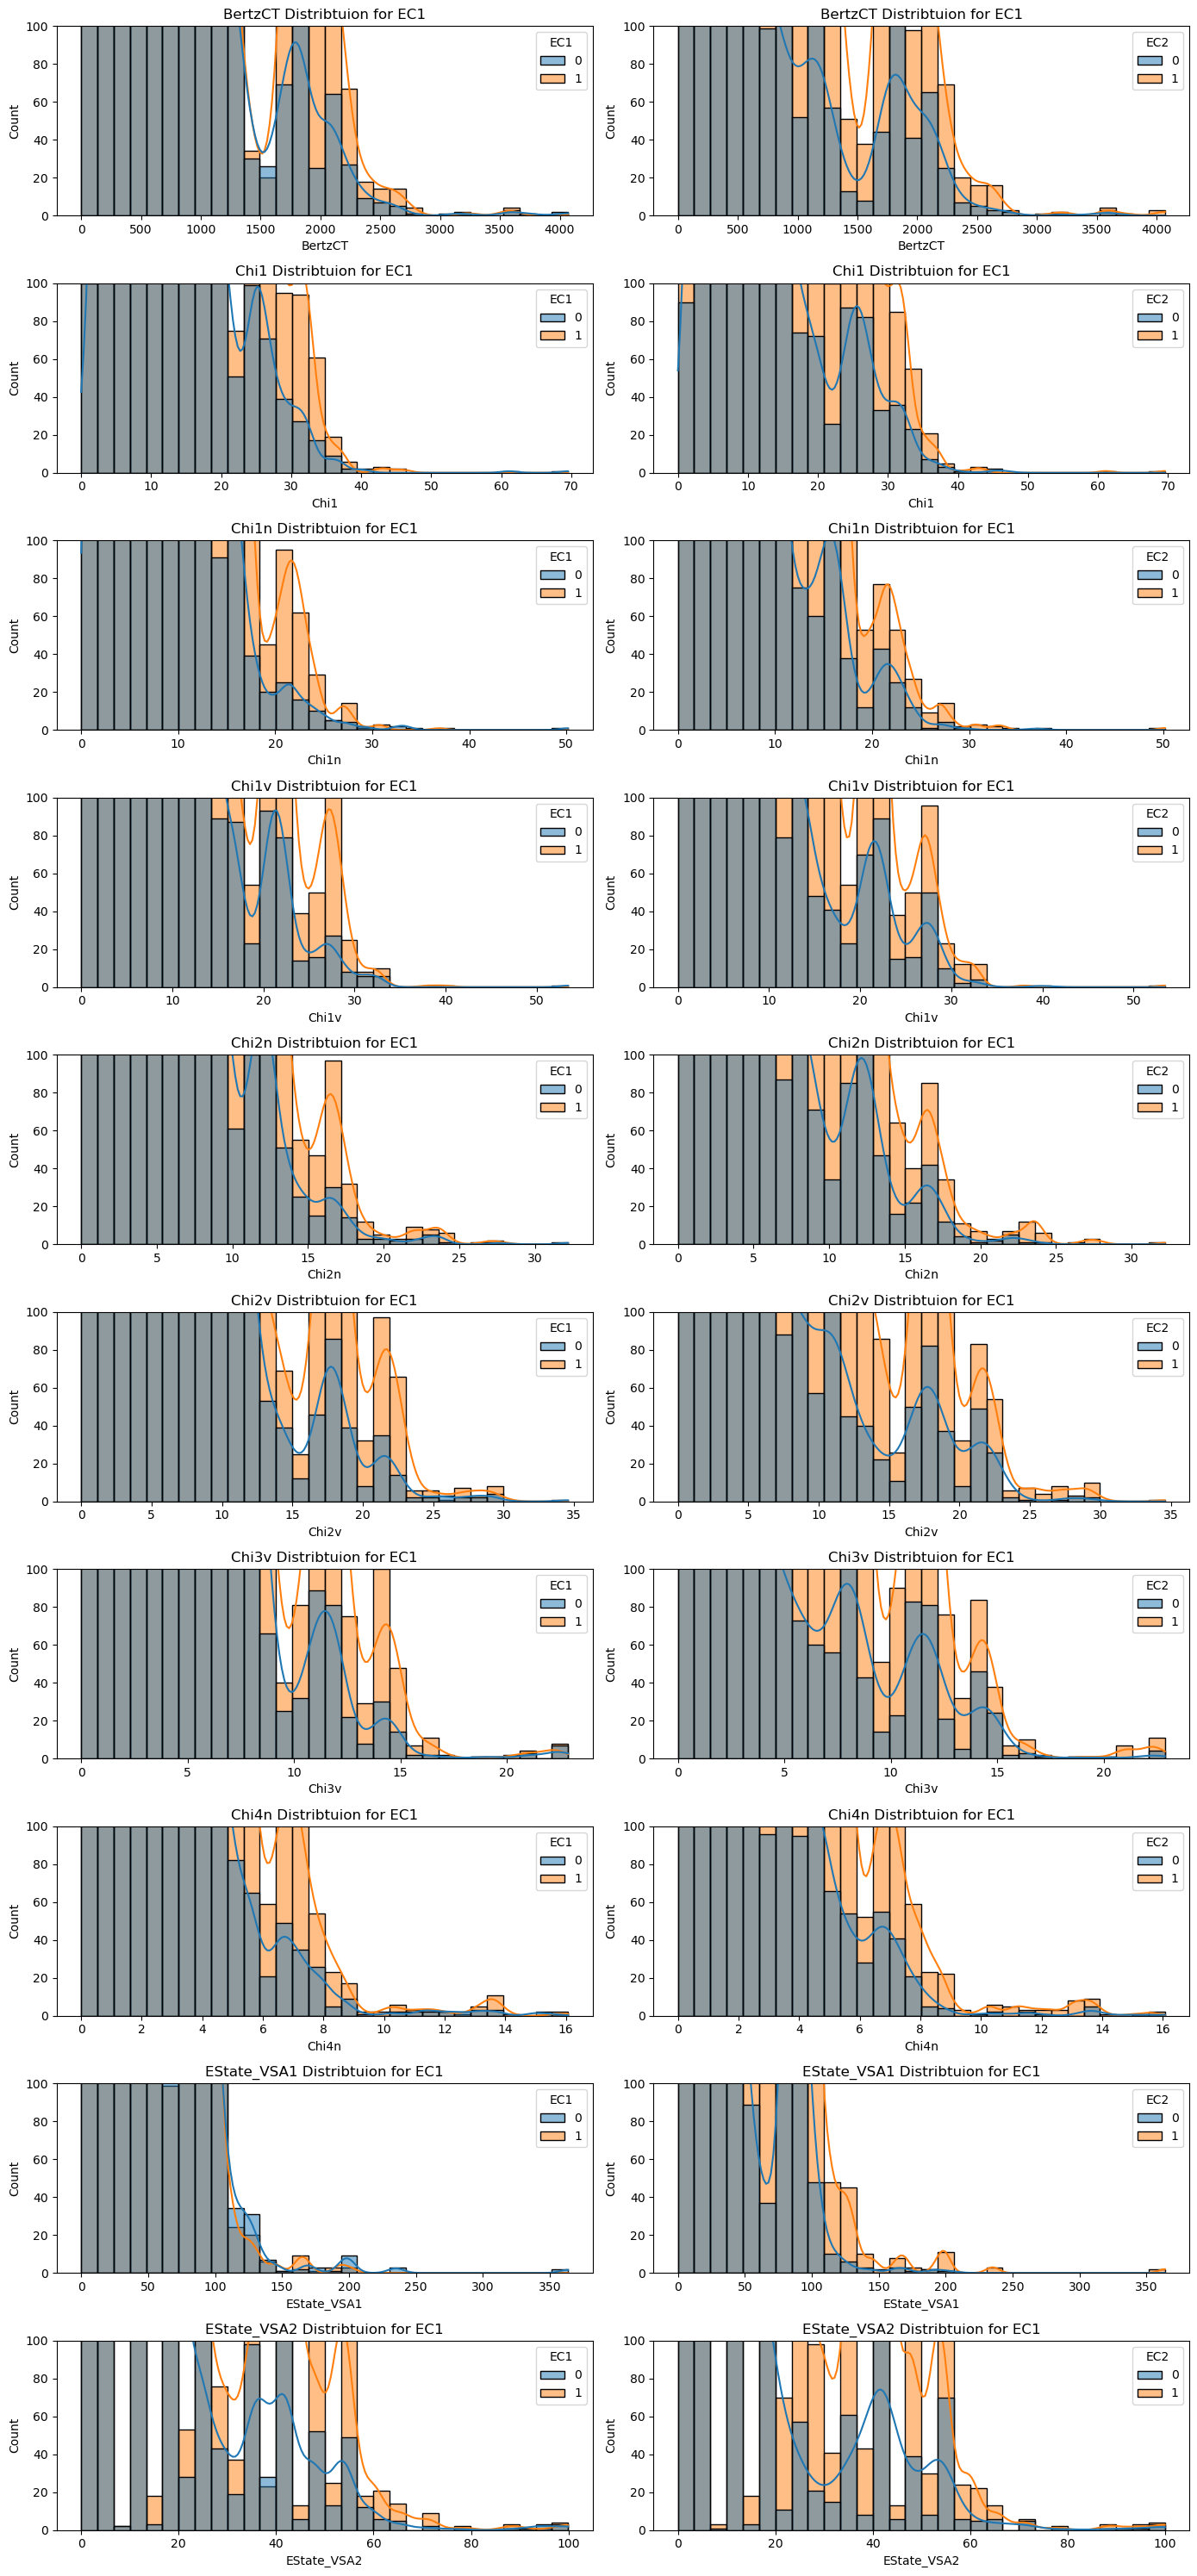

In [7]:
plt.figure(figsize=(14, 30))
# Plot only for first 10 features
for idx, column in enumerate(features[:10]):
    # plot for 'EC1'
    plt.subplot(10, 2, idx*2+1)
    sns.histplot(x=column, hue='EC1', data=train, bins=30, kde=True)
    plt.title(f"{column} Distribtuion for EC1")
    plt.ylim(0,100)
    plt.tight_layout()

    # plot for 'EC2'
    plt.subplot(10, 2, idx*2+2)
    sns.histplot(x=column, hue='EC2', data=train, bins=30, kde=True)
    plt.title(f"{column} Distribtuion for EC1")
    plt.ylim(0,100)
    plt.tight_layout()

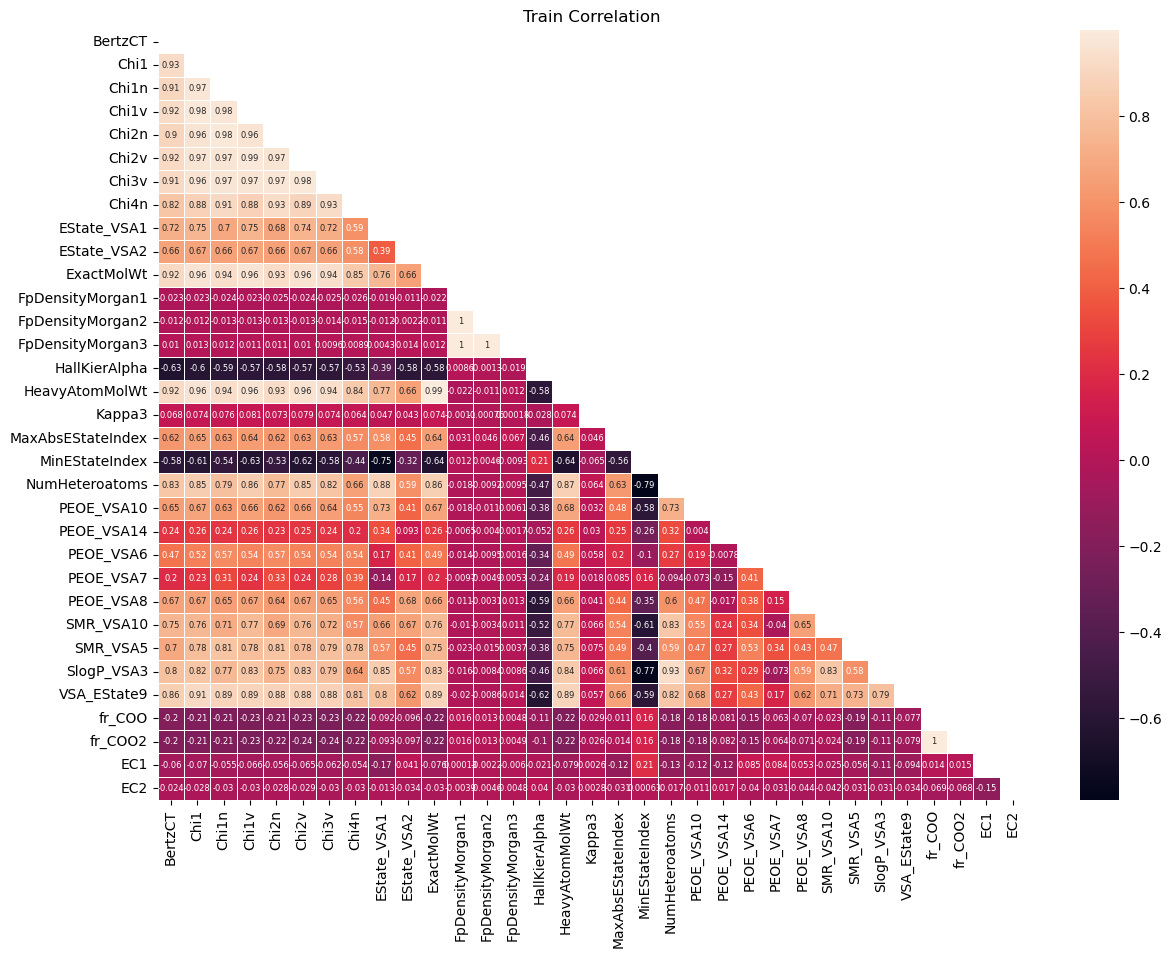

In [8]:
# Correlation heatmap
def correlation_heatmap(df: pd.core.frame.DataFrame, title_name: str) -> None:
    excluded_columns = ['id', 'EC3', 'EC4', 'EC5', 'EC6']

    columns_included = [col for col in df.columns if col not in excluded_columns]

    corr = df[columns_included].corr()
    fig, axes = plt.subplots(figsize=(14,10))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, linewidths=.5, annot=True, annot_kws={'size':6}) 
    # annot: write the data value in each cell
    plt.title(title_name)
    plt.show()
   
correlation_heatmap(train[columns], 'Train Correlation')

In [9]:
# drop useless columns
train.drop(['id', 'EC3', 'EC4', 'EC5', 'EC6'], axis=1, inplace=True)
print(train.head())

      BertzCT       Chi1     Chi1n      Chi1v     Chi2n      Chi2v     Chi3v  \
0  323.390782   9.879918  5.875576   5.875576  4.304757   4.304757  2.754513   
1  273.723798   7.259037  4.441467   5.834958  3.285046   4.485235  2.201375   
2  521.643822  10.911303  8.527859  11.050864  6.665291   9.519706  5.824822   
3  567.431166  12.453343  7.089119  12.833709  6.478023  10.978151  7.914542   
4  112.770735   4.414719  2.866236   2.866236  1.875634   1.875634  1.036450   

      Chi4n  EState_VSA1  EState_VSA2  ...  PEOE_VSA7  PEOE_VSA8  SMR_VSA10  \
0  1.749203     0.000000    11.938294  ...   0.000000   0.000000  17.744066   
1  1.289775    45.135471     0.000000  ...   0.000000   0.000000   7.822697   
2  1.770579    15.645394     6.606882  ...  53.378235   0.000000  15.645394   
3  3.067181    95.639554     0.000000  ...   0.000000   6.420822  15.645394   
4  0.727664    17.980451    12.841643  ...  19.386400   0.000000  11.938611   

    SMR_VSA5  SlogP_VSA3  VSA_EState9  fr_CO

In [10]:
# Target Columns
target_cols = ['EC1', 'EC2']

# Normalize the features
scaler = StandardScaler()
train[features] = scaler.fit_transform(train[features])
test[features] = scaler.transform(test[features])

In [17]:
# Hyperparameter tuning with Optuna
def objectiveEC1(trial):
    # Load dataset
    X, y = train[features], train['EC1']

    # Split into train and validation sets
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=302, stratify=y)
    # stratify: data is split in a stratified fashion, using this as the class labels

    # Hyperparameters to optimize
    params = {
        'objective': 'binary:logistic', 
        'booster': 'gbtree', 
        'verbosity': 0, 
        'tree_method': 'hist', 
        'n_estimators': trial.suggest_int('n_estimators', 100, 500), 
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0), 
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0), 
        'max_depth': trial.suggest_int('max_depth', 3, 10), 
        'eta': trial.suggest_float('eta', 0.01, 0.1), 
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0), 
        'subsample': trial.suggest_float('subsample', 0.6, 0.9), 
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.9), 
        'mid_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }

    model = XGBClassifier(**params, random_state=302, n_jobs=-1)
    watchlist = [(X_valid, y_valid)]
    model.fit(X_train, y_train, eval_set=watchlist, verbose=0)
    val_preds = model.predict_proba(X_valid)[:, 1]
    val_score = roc_auc_score(y_valid, val_preds)

    return val_score

In [18]:
obj_EC1 = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
obj_EC1.optimize(objectiveEC1, n_trials=300)

[I 2023-06-28 14:35:40,805] A new study created in memory with name: no-name-9741264b-b7ef-4172-97ec-7a86aa18cb0e
[I 2023-06-28 14:35:41,312] Trial 0 finished with value: 0.6891542134791214 and parameters: {'n_estimators': 100, 'lambda': 0.40311379445166606, 'alpha': 0.15462673926524836, 'max_depth': 6, 'eta': 0.03973847531678634, 'gamma': 0.14016238082031154, 'subsample': 0.7759525575405233, 'colsample_bytree': 0.5427555424412283, 'min_child_weight': 7}. Best is trial 0 with value: 0.6891542134791214.
[I 2023-06-28 14:35:42,504] Trial 1 finished with value: 0.6729838321772218 and parameters: {'n_estimators': 119, 'lambda': 0.09434040363270237, 'alpha': 0.3569508312054051, 'max_depth': 10, 'eta': 0.0751613349148189, 'gamma': 0.4398803641724258, 'subsample': 0.8726445110791918, 'colsample_bytree': 0.8515038781535923, 'min_child_weight': 8}. Best is trial 0 with value: 0.6891542134791214.
[I 2023-06-28 14:35:44,505] Trial 2 finished with value: 0.6802518303678338 and parameters: {'n_esti

In [19]:
# Hyperparameter tuning with Optuna
def objectiveEC2(trial):
    # Load dataset
    X, y = train[features], train['EC2']

    # Split into train and validation sets
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=302, stratify=y)
    # stratify: data is split in a stratified fashion, using this as the class labels

    # Hyperparameters to optimize
    params = {
        'objective': 'binary:logistic', 
        'booster': 'gbtree', 
        'verbosity': 0, 
        'tree_method': 'hist', 
        'n_estimators': trial.suggest_int('n_estimators', 100, 500), 
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0), 
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0), 
        'max_depth': trial.suggest_int('max_depth', 3, 10), 
        'eta': trial.suggest_float('eta', 0.01, 0.1), 
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0), 
        'subsample': trial.suggest_float('subsample', 0.6, 0.9), 
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.9), 
        'mid_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }

    model = XGBClassifier(**params, random_state=302, n_jobs=-1)
    watchlist = [(X_valid, y_valid)]
    model.fit(X_train, y_train, eval_set=watchlist, verbose=0)
    val_preds = model.predict_proba(X_valid)[:, 1]
    val_score = roc_auc_score(y_valid, val_preds)

    return val_score

In [20]:
obj_EC2 = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
obj_EC2.optimize(objectiveEC2, n_trials=300)

[I 2023-06-28 14:39:29,803] A new study created in memory with name: no-name-986c2f9a-be8f-449d-b862-a744a74d08da
[I 2023-06-28 14:39:30,976] Trial 0 finished with value: 0.5742772628784298 and parameters: {'n_estimators': 275, 'lambda': 0.6335652538801742, 'alpha': 0.619356728393893, 'max_depth': 6, 'eta': 0.05051099211501019, 'gamma': 0.9576773742678304, 'subsample': 0.6949660208975044, 'colsample_bytree': 0.8438797255783126, 'min_child_weight': 8}. Best is trial 0 with value: 0.5742772628784298.
[I 2023-06-28 14:39:32,038] Trial 1 finished with value: 0.5467489281074287 and parameters: {'n_estimators': 287, 'lambda': 0.6335719842791745, 'alpha': 0.6364743803509343, 'max_depth': 5, 'eta': 0.09139457652208083, 'gamma': 0.15716306220160914, 'subsample': 0.7348427662502501, 'colsample_bytree': 0.5247561116880203, 'min_child_weight': 3}. Best is trial 0 with value: 0.5742772628784298.
[I 2023-06-28 14:39:32,878] Trial 2 finished with value: 0.5642743451547065 and parameters: {'n_estimato

In [21]:
# XGBClassifier models for each target, namely EC1 and EC2
models = {'EC1': XGBClassifier(**obj_EC1.best_params), 'EC2': XGBClassifier(**obj_EC2.best_params)}

# Training Parameters
FOLDS = 10
SEED = 302
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

# Dictionaries to store results
oof = {target: [] for target in target_cols} # Out Of Fold
auc_scores = {target: [] for target in target_cols} # Area Under (ROC) Curve
best_iters = {target: [] for target in target_cols}
best_models = {target: None for target in target_cols}
best_auc = {target: 0 for target in target_cols}

# Train Models
for target in target_cols:
    print(f'Training model for {target}')
    y = train[target]
    for fold, (train_idx, val_idx) in enumerate(skf.split(train, y)):
        print(f'##################### Training FOLD {fold+1} #####################')
        X_train, y_train = train.iloc[train_idx][features], y.iloc[train_idx]
        X_valid, y_valid = train.iloc[val_idx][features], y.iloc[val_idx]
        watchlist = [(X_train, y_train), (X_valid, y_valid)]
        model = models[target]
        model.fit(X_train, y_train, eval_set = watchlist, verbose=0)
        val_preds = model.predict_proba(X_valid)[:, 1]
        val_score = roc_auc_score(y_valid, val_preds)
        print(f'auc: {val_score:.5f}     best iteration: {model.get_booster().best_iteration}')
        oof[target].append(val_preds)
        auc_scores[target].append(val_score)
        best_iters[target].append(model.get_booster().best_iteration)
        # Save the Best Model
        if val_score > best_auc[target]:
            best_auc[target] = val_score
            best_models[target] = model
    print('-------------------------------------------------')
    print(f'Mean AUC for {target}: {np.mean(auc_scores[target]):.5f}')
    print('-------------------------------------------------')


Training model for EC1
##################### Training FOLD 1 #####################
auc: 0.72701     best iteration: 141
##################### Training FOLD 2 #####################
auc: 0.69989     best iteration: 141
##################### Training FOLD 3 #####################
auc: 0.70162     best iteration: 141
##################### Training FOLD 4 #####################
auc: 0.69614     best iteration: 141
##################### Training FOLD 5 #####################
auc: 0.72161     best iteration: 141
##################### Training FOLD 6 #####################
auc: 0.70882     best iteration: 141
##################### Training FOLD 7 #####################
auc: 0.70003     best iteration: 141
##################### Training FOLD 8 #####################
auc: 0.70381     best iteration: 141
##################### Training FOLD 9 #####################
auc: 0.70624     best iteration: 141
##################### Training FOLD 10 #####################
auc: 0.69304     best iteration: 141
------

In [22]:
# Visualization Function for the Results
def f_importance_plot(f_imp):
    fig = plt.figure(figsize=(12, 0.2*len(f_imp)))
    plt.title('Feature Importances')
    a = sns.barplot(data=f_imp, x='avg_imp', y='feature', linestyle='-', linewidth=0.5, edgecolor='black')
    plt.xlabel('')
    plt.xticks([])
    plt.ylabel('')
    plt.yticks(size=11)

    # 테두리 제거
    for j in ['right', 'top', 'bottom']:
        a.spines[j].set_visible(False)

    a.spines['left'].set_linewidth(0.5)
    
    plt.tight_layout()
    plt.show()

def show_confusion_roc(preds: np.array, target: np.array) -> None:
    """
    Draws a confusion matrix and roc_curve with AUC score.

        Args:
            preds: Predictions from the model.
            target: True labels
    """

    f, ax = plt.subplots(1, 2, figsize=(13, 4))
    df = pd.DataFrame({'preds': preds, 'target': target})
    cm = confusion_matrix(df.target, df.preds.ge(0.5).astype(int))
    cm_display = ConfusionMatrixDisplay(cm).plot(ax=ax[0])
    ax[0].grid(False)
    RocCurveDisplay.from_predictions(df.target, df.preds, ax=ax[1])
    plt.tight_layout()

def get_mean_auc(oof, target):
    """ oof: ['val_idx', 'preds', 'target']"""
    mean_val_auc = roc_auc_score(train[target], oof)

    return mean_val_auc

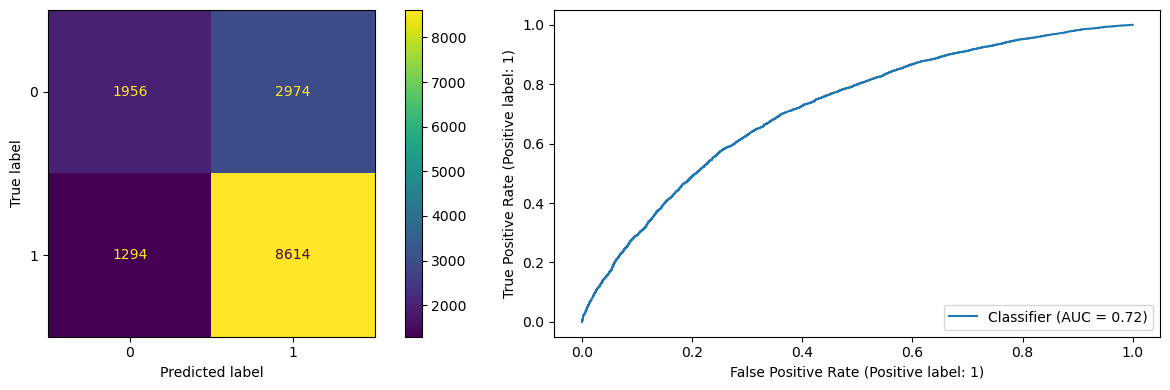

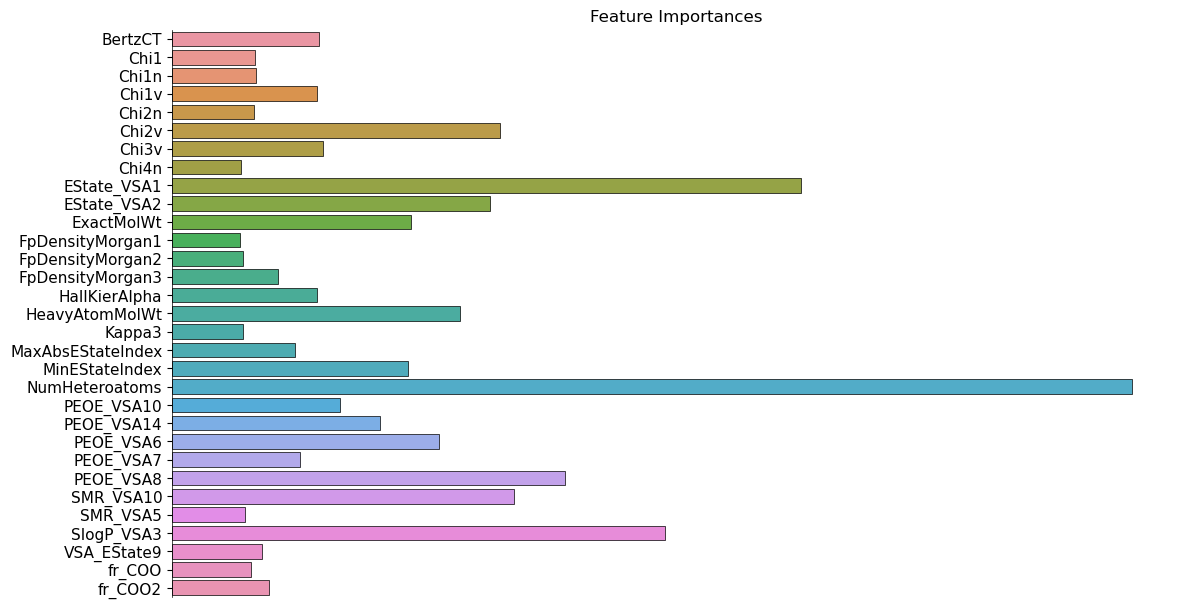

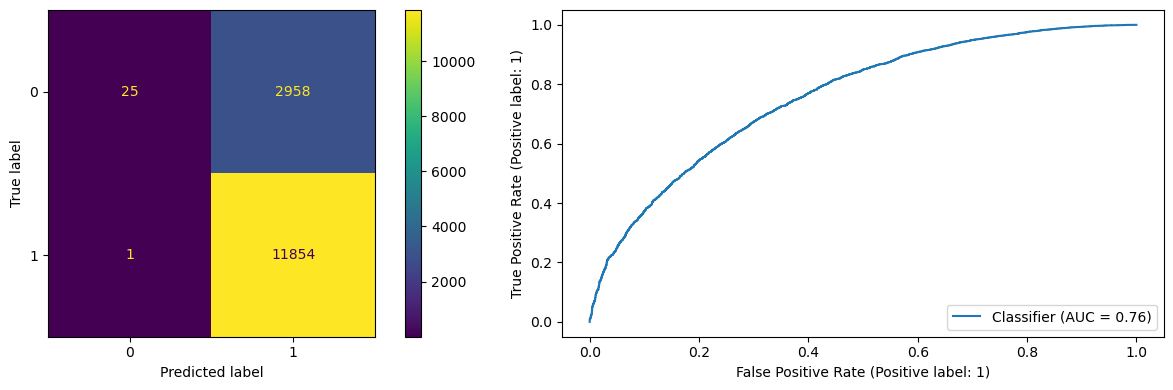

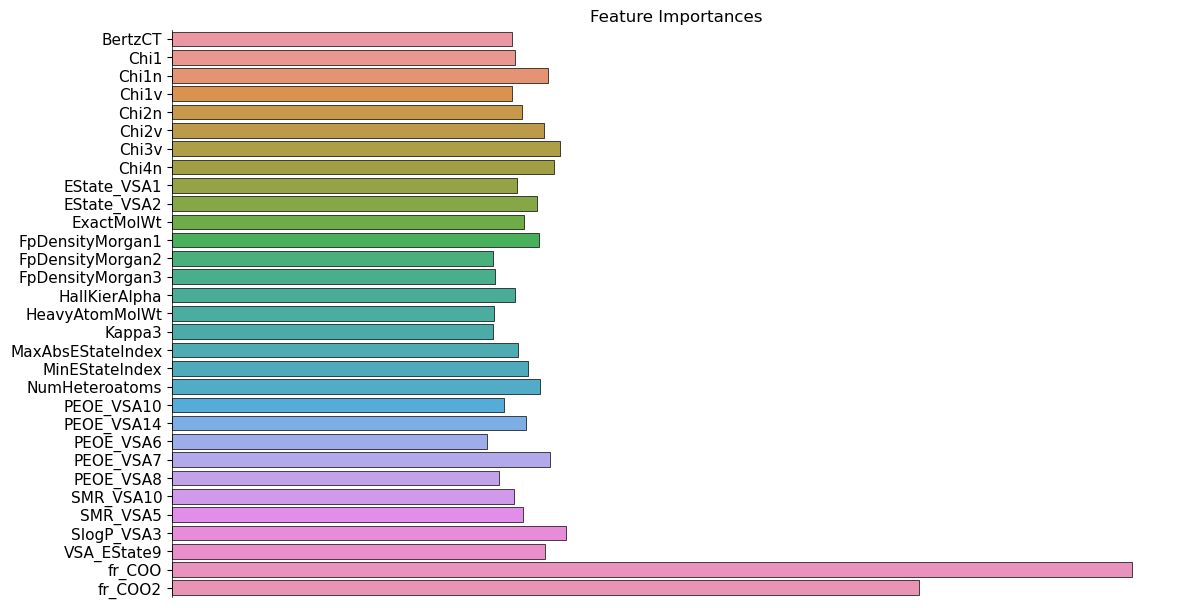

In [23]:
# Visualazation for EC1
best_val_preds_EC1 = best_models['EC1'].predict_proba(train[features])[:, 1]
show_confusion_roc(best_val_preds_EC1, train['EC1'])
f_imp_df = pd.DataFrame({'feature': features, 'avg_imp': best_models['EC1'].feature_importances_})
f_importance_plot(f_imp_df)

# Visualazation for EC2
best_val_preds_EC1 = best_models['EC2'].predict_proba(train[features])[:, 1]
show_confusion_roc(best_val_preds_EC1, train['EC2'])
f_imp_df = pd.DataFrame({'feature': features, 'avg_imp': best_models['EC2'].feature_importances_})
f_importance_plot(f_imp_df)


참고자료: https://www.kaggle.com/code/kimtaehun/multi-label-classification-with-complete-eda